# Plots for blog post

Get all data from "woof" experiment

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from langsmith.client import Client

from langchain_benchmarks import (
    __version__,
    clone_public_dataset,
    model_registry,
    registry,
)
from langchain_benchmarks.rate_limiting import RateLimiter
from langchain_benchmarks.tool_usage.agents import (
    AnthropicToolUserFactory,
    CustomAgentFactory,
    OpenAIAgentFactory,
    OpenAIAssistantFactory,
)

In [2]:
from datetime import datetime

client = Client()

In [3]:
experiment_ids = ["woof"]


def _endswith(s, suffixes):
    return any(s.endswith(suffix) for suffix in suffixes)


client = Client()
projects = [
    project
    for project in client.list_projects()
    if _endswith(project.name, experiment_ids)
]

print("\n".join(sorted([project.name for project in projects])))

claude-2.1-anthropic_tool_user-Multiverse Math-2023-12-19-woof
claude-2.1-anthropic_tool_user-Tool Usage - Relational Data-2023-12-18-woof
claude-2.1-anthropic_tool_user-Tool Usage - Typewriter (1 tool)-2023-12-18-woof
claude-2.1-anthropic_tool_user-Tool Usage - Typewriter (26 tools)-2023-12-18-woof
gemini-pro-custom_agent-Multiverse Math-2023-12-19-woof
gemini-pro-custom_agent-Tool Usage - Relational Data-2023-12-18-woof
gpt-3.5-turbo-0613-openai_functions-Multiverse Math-2023-12-19-woof
gpt-3.5-turbo-0613-openai_functions-Tool Usage - Relational Data-2023-12-18-woof
gpt-3.5-turbo-0613-openai_functions-Tool Usage - Typewriter (1 tool)-2023-12-18-woof
gpt-3.5-turbo-0613-openai_functions-Tool Usage - Typewriter (26 tools)-2023-12-18-woof
gpt-3.5-turbo-1106-openai_assistant-Multiverse Math-2023-12-19-woof
gpt-3.5-turbo-1106-openai_assistant-Tool Usage - Relational Data-2023-12-18-woof
gpt-3.5-turbo-1106-openai_assistant-Tool Usage - Typewriter (1 tool)-2023-12-18-woof
gpt-3.5-turbo-1106-

In [4]:
dfs = []
for project in projects:
    # Temporary way to get tag information
    project_info = client.read_project(project_id=project.id)

    if project_info.extra is None:
        continue
        # raise ValueError(project.name)
    try:
        test_results = client.get_test_results(project_name=project.name)
    except Exception:
        continue

    for k, v in project_info.extra["metadata"].items():
        test_results[k] = v

    dfs.append(test_results)


df = pd.concat(dfs)

In [8]:
# pd.set_option('display.max_colwidth', None)
# subset_df.sort_values(['model', 'input.question', 'arch'])[['model', 'input.question', 'outputs.output', 'reference.reference', 'correct']].iloc[:50]

Compute some statistics. We're using estimating standard error of the mean assuming a bernoulli process.

In [6]:
tasks = [
    "Tool Usage - Typewriter (1 tool)",
    "Tool Usage - Typewriter (26 tools)",
    "Multiverse Math",
    "Tool Usage - Relational Data",
]


correct = []

for r in df.to_dict(orient="records"):
    if "Typewriter" in r["task"]:
        correct.append(r["feedback.Correct Final State"])
    else:
        correct.append(r["feedback.correctness"])

df["correct"] = correct
df["correct"].fillna(0, inplace=True)

num_correct = (
    df.groupby(["model", "arch", "task"])["correct"].sum().to_frame("num_correct")
)
total = df.groupby(["task", "arch", "model"]).size().to_frame("total")
stats_df = total.join(num_correct)
stats_df["% correct"] = stats_df["num_correct"] / stats_df["total"]
stats_df["error"] = np.sqrt(
    stats_df["% correct"] * (1 - stats_df["% correct"]) / stats_df["total"]
)

stats_df = stats_df.reset_index()

names = []
for r in stats_df.to_dict(orient="records"):
    if r["model"].startswith("gpt"):
        if r["arch"] == "openai_assistant":
            names.append(f"{r['model']} (assistant)")
        else:
            names.append(f"{r['model']} (functions)")
    elif r["model"].endswith("-fw"):
        names.append(r["model"].removesuffix("-fw"))
    else:
        names.append(r["model"])


stats_df["model"] = names

In [9]:
list(stats_df.model.unique())

['claude-2.1',
 'gemini-pro',
 'llama-v2-13b-chat',
 'llama-v2-70b-chat',
 'mixtral-8x7b-instruct',
 'yi-34b-200k',
 'gpt-3.5-turbo-1106 (assistant)',
 'gpt-4-1106-preview (assistant)',
 'gpt-3.5-turbo-0613 (functions)',
 'gpt-3.5-turbo-1106 (functions)',
 'gpt-4-0613 (functions)',
 'gpt-4-1106-preview (functions)',
 'mistral-7b-instruct-v0.1']

In [10]:
stats_df

,task,arch,model,total,num_correct,% correct,error
0,Multiverse Math,anthropic_tool_user,claude-2.1,20,12.0,0.600000,0.109545
1,Multiverse Math,custom_agent,gemini-pro,20,7.0,0.350000,0.106654
2,Multiverse Math,custom_agent,llama-v2-13b-chat,20,4.0,0.200000,0.089443
3,Multiverse Math,custom_agent,llama-v2-70b-chat,20,5.0,0.250000,0.096825
4,Multiverse Math,custom_agent,mixtral-8x7b-instruct,20,4.0,0.200000,0.089443
5,Multiverse Math,custom_agent,yi-34b-200k,20,1.0,0.050000,0.048734
6,Multiverse Math,openai_assistant,gpt-3.5-turbo-1106 (assistant),20,9.0,0.450000,0.111243
7,Multiverse Math,openai_assistant,gpt-4-1106-preview (assistant),20,9.0,0.450000,0.111243
8,Multiverse Math,openai_functions,gpt-3.5-turbo-0613 (functions),20,14.0,0.700000,0.102470
9,Multiverse Math,openai_functions,gpt-3.5-turbo-1106 (functions),20,10.0,0.500000,0.111803


## Color palette

In [11]:
import seaborn as sns

pallete = sns.color_palette("colorblind")

pallete

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

# Individual plots

In [72]:
models = [
    # 'llama-v2-13b-chat',
    # 'llama-v2-70b-chat',
    # 'yi-34b-200k',
    # "mistral-7b-instruct-v0.1",
    # "mixtral-8x7b-instruct",
    "gemini-pro",
    "claude-2.1",
    "gpt-3.5-turbo-0613 (functions)",
    "gpt-3.5-turbo-1106 (functions)",
    'gpt-3.5-turbo-1106 (assistant)',
    "gpt-4-0613 (functions)",
    "gpt-4-1106-preview (functions)",
    'gpt-4-1106-preview (assistant)',
    

]

In [75]:
assert len(models) <= len(pallete)
model_to_color = dict(zip(models, pallete))

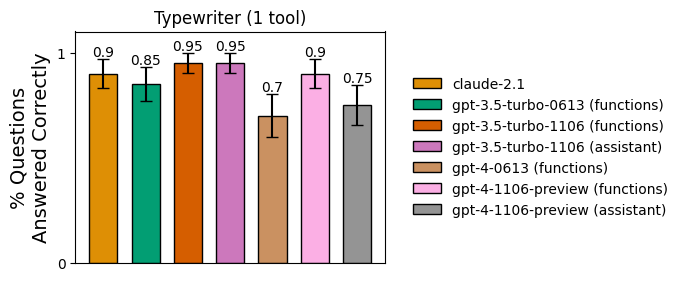

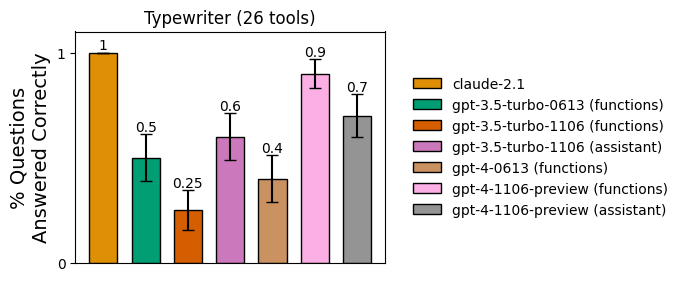

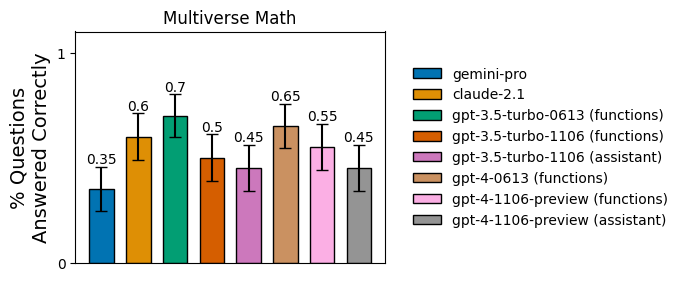

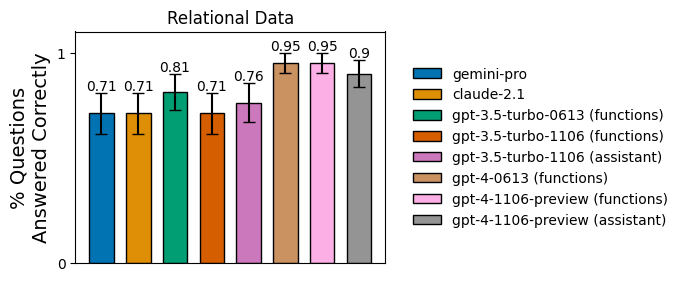

In [77]:
for idx, task in enumerate(tasks):
    fig, ax = plt.subplots(1, figsize=(4, 3))
    task_df = stats_df.set_index("task").loc[task].reset_index().set_index("model")
    existing_models = set(task_df.index.tolist())
    models_for_task = [model for model in models if model in existing_models]
    labels = list(models_for_task)
    colors = [model_to_color[model] for model in models_for_task]
    task_df = stats_df.set_index("task").loc[task].reset_index().set_index("model")
    ax.set_title(task.removeprefix("Tool Usage - "))
    xs = np.arange(len(models_for_task)) * 0.3

    # Plot the content
    yerrs = []
    values = []
    for model in models_for_task:
        record = task_df.loc[model]
        values.append(round(record["% correct"], 2))
        yerrs.append(record["error"])
        
    rects = ax.bar(
        xs,
        values,
        0.2,
        label=labels, 
        yerr=yerrs,
        color=colors,
        edgecolor="black",
        capsize=4,
    )
    ax.bar_label(rects, padding=0, label_type="edge")
    ax.set_ylim(0, 1.1)
    ax.set_yticks([0, 1])
    ax.set_xticks([])

    ax.set_ylabel("% Questions\nAnswered Correctly", fontdict={"size": 14})
    # ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.6), frameon=False)
    ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), frameon=False)